In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import torch.distributions as D
import torch.nn.functional as F
from scipy.interpolate import griddata

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


cuda:0


In [2]:
# global veriable
Uniform_low_bound = 0
Uniform_up_bound = 1
Agent_number_n = 3
number_of_groups = 2
Normal_loc = 0.5
Normal_scale = 0.2
Normal_loc1 = 0
Normal_loc2 = 1.5
Normal_scale1 = 0.2
Normal_scale2 = 0.2
Distribution_number = 5000

beta_a = 0.3
beta_b = 0.2
cauchyloc = 1.0/Agent_number_n
cauchyscalen = 0.004
kumaraswamy_a = beta_a
kumaraswamy_b = (1.0 + (beta_a - 1.0) * math.pow(
    (beta_a + beta_b - 2.0) / (beta_a - 1.0), beta_a)) / beta_a
print(kumaraswamy_b)

independentnormalloc1 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(Agent_number_n, 0, -1)]
independentnormalscale1 = [0.05 for ii in range(Agent_number_n)]

independentnormalloc2 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(1, Agent_number_n + 1, 1)]
independentnormalscale2 = [0.05 for ii in range(Agent_number_n)]
exponentialhigh = 15  #Symbol("b", real=True)
exponentiallow = 15  #Symbol("a", real=True)

target = "min_sum" 
#target = "min_max"
order = "twopeaknormal"
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name = ["dp", "random initializing", "costsharing", "heuristic"]
# "costsharing","dp","heuristic","random initializing"

0.40058530825361593


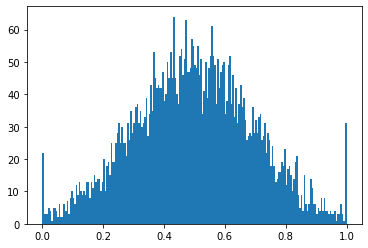

2500
[[0.53629287 0.75777657 0.54006023]
 [0.33936184 0.49853522 0.99969725]
 [0.4513505  0.44359308 0.5307268 ]]
2500


In [3]:
seed = 7
np.random.seed(seed)
# exec(open('distribution/twopeak.py').read())
#exec(open('../distribution/twopeaknormal.py').read())
exec(open('../distribution/normal.py').read())
X_train, X_test = train_test_split(value_list,
                                   test_size=0.5,
                                   random_state=seed)
for i in range(len(value_list)):
    for j in range(len(value_list[0])):
        if (value_list[i][j] <= 0):
            value_list[i][j] = 0
        if (value_list[i][j] >= 1):
            value_list[i][j] = 1

value_list1 = np.array(value_list)
for i in range(min(Agent_number_n, 1)):
    pa = value_list1[:, i]
    plt.hist(pa, bins=200)
    plt.show()

dataset_size = len(X_train)
print(dataset_size)
print(np.array(X_train[:3]))
print(len(X_test))
# run_cs()

In [4]:
d1 = D.normal.Normal(Normal_loc1, Normal_scale1)
d2 = D.normal.Normal(Normal_loc2, Normal_scale2)
distributionRatio1 = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase1 = d1.cdf(0) + d2.cdf(0)

d3 = D.normal.Normal(Normal_loc, Normal_scale)
distributionRatio3 = d3.cdf(1) - d3.cdf(0)
distributionBase3 = d3.cdf(0)

d4 = D.uniform.Uniform(0.0, 1.0)
distributionRatio4 = d4.cdf(1) - d4.cdf(0)
distributionBase4 = d4.cdf(0)

d5 = [
    D.normal.Normal(independentnormalloc1[ii], independentnormalscale1[ii])
    for ii in range(Agent_number_n)
]
d6 = [
    D.normal.Normal(independentnormalloc2[ii], independentnormalscale2[ii])
    for ii in range(Agent_number_n)
]

d7 = D.cauchy.Cauchy(cauchyloc, cauchyscalen)
d81 = D.exponential.Exponential(exponentiallow)
d82 = D.exponential.Exponential(exponentialhigh)

d9 = D.beta.Beta(beta_a, beta_b)
d10 = D.beta.Beta(0.5, 0.5)


def cdf(x, y, i=None):
    if (y == "twopeaknormal"):
        return (d1.cdf(x) + d2.cdf(x) ) / 2 #/ distributionRatio1
    elif (y == "normal"):
        return (d3.cdf(x) - distributionBase3) #/ distributionRatio3
    elif (y == "uniform"):
        return (d4.cdf(x) - distributionBase4) #/ distributionRatio4
    elif (y == "independent1"):
        return d5[i].cdf(x)
    elif (y == "independent2"):
        return d6[i].cdf(x)
    elif (y == "cauchy"):
        return d7.cdf(x)
    elif (y == "beta"):
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            return 1.0 - torch.pow(1.0 - torch.pow(x, kumaraswamy_a),
                                   kumaraswamy_b)
        except:
            return 1.0 - torch.pow(
                1.0 - torch.pow(torch.tensor(x, dtype=torch.float32),
                                kumaraswamy_a), kumaraswamy_b)
    elif (y == "arcsine"):
        #
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            res = 2.0 / math.pi * torch.asin(torch.sqrt(x))
            # print(x)
            return res  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
        except:
            return 2.0 / math.pi * torch.asin(
                torch.sqrt(torch.tensor(
                    x, dtype=torch.float32)))  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
    elif (y == "U-exponential"):
        return (d81.cdf(x) + (1.0 - d82.cdf(1.0 - x))) / 2

In [5]:
x=torch.nn.Parameter(torch.tensor(0.2,
                                                      requires_grad=True),
                                           requires_grad=True).cuda()
print(cdf(1.3717421124828532235939643347051, order))

print(cdf(0.5, order))

tensor(0.6303)
tensor(0.4969)


In [6]:
global iteration,echo

def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight,
                                     gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n
        num_hidden = 50
        num_output = Agent_number_n

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_3 = torch.nn.Linear(num_hidden, num_hidden)
        self.output_allocation = torch.nn.Linear(num_hidden, num_output)

    def calculate(self, value_list):
        h1 = torch.relu_(self.hidden_0(value_list))
        h2 = torch.relu_(self.hidden_1(h1))
        h3 = torch.relu_(self.hidden_2(h2))
        h4 = torch.relu_(self.hidden_3(h3))
        allocation_temp = torch.sigmoid(self.output_allocation(h4))

        return allocation_temp

    def forward(self, value_list):
        global iteration,echo
        
        value_list = torch.from_numpy(
            np.array(value_list)).cuda().type(torch.float32)

        allocation = self.calculate(value_list)

        loss_condition = 0
        loss_sum_delay = 0
        loss_max_delay = 0

        payment = torch.zeros(Agent_number_n).cuda()

        for i in range(Agent_number_n):
            devide = 10

            payment[i] = allocation[i] * value_list[i]
            integral = 0
            for c in range(devide):

                payment_change_1 = (torch.tensor(float(c) / devide)).cuda()
                value_list_temp_1 = value_list.clone()
                value_list_temp_1[i] = payment_change_1

                allocation_temp_1 = self.calculate(
                    value_list_temp_1)

                payment_change_2 = (torch.tensor(float(c+1) / devide)).cuda()
                value_list_temp_2 = value_list.clone()
                value_list_temp_2[i] = payment_change_2

                allocation_temp_2 = self.calculate(
                    value_list_temp_2)

                loss_constant = torch.relu(
                    allocation_temp_1[i] - allocation_temp_2[i])

                if((torch.tensor(float(c) / devide)).cuda() < value_list[i]):
                    integral += (torch.tensor(float(1) / devide)
                                 ).cuda() * allocation_temp_1[i]
                    loss_constant += torch.relu(
                        allocation_temp_1[i] - allocation[i])

                elif((torch.tensor(float(c+1) / devide)).cuda() < value_list[i]):
                    integral += (value_list[i] - (torch.tensor(float(1) /
                                                               devide)).cuda()) * allocation_temp_1[i]
                    loss_constant += torch.relu(
                        allocation_temp_1[i] - allocation[i])

                loss_condition += loss_constant

            payment[i] -= integral

            loss_condition += torch.relu(payment[i]-value_list[i])

        loss_max_delay += torch.max(1.0 - allocation)

        loss_sum_delay += torch.sum(1.0 - allocation)

        #loss_condition += torch.relu(torch.sigmoid(torch.sum(allocation)*100) - torch.sum(payment))
        loss_condition += torch.where(torch.sum(allocation) > torch.tensor(1e-4).cuda(),
                                      torch.square(torch.sigmoid(torch.sum(allocation)*100-20) - torch.sum(payment)),
                                      #torch.relu(torch.sigmoid(torch.sum(allocation)*100-20) - torch.sum(payment)),
                                      torch.tensor(0.).cuda())
        
        sub1 = torch.sigmoid(torch.sum(allocation)*100-20) - torch.tensor(1e-4).cuda()
        
        p1 = torch.sigmoid(sub1/(100*iteration/echo))
        
        loss_condition += torch.sigmoid(sub1) * torch.relu(sub1)

        if(target == "min_sum"):
            loss = loss_sum_delay + loss_condition * 100
        if(target == "min_max"):
            loss = loss_max_delay + loss_condition * 100

        return loss, loss_sum_delay, loss_max_delay, float(loss_condition), payment.cpu(
        ).data.numpy(), allocation.cpu(
        ).data.numpy()

In [7]:
random.seed(2000)
torch.manual_seed(256)
net = Net()
# net.apply(weight_init)
#net = torch.load("Deep_learning_3_normal_3")
net.to(dev)

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.002)
optimizer = opt.Adam(net.parameters(), lr=0.00005)

batch_size = 4
echo = 5001

In [8]:


for i in range(int(echo)):
    iteration=i
    # offender_types = []
    # defender_types = []
    loss_sum = 0
    denominator = 0
    """
    for j in range(batch_size):
        offender_types.append(random.randint(0, 400))
        defender_types.append(random.randint(0, 15))
    """
    X_train_list = []
    for j in range(batch_size):
        index_random = random.randint(0, len(X_train) - 1)
        h_loss, h_delay_sum, h_delay_max, h_condition, payment_R, pay_time_R = net(
            X_train[index_random])
        denominator += 1
        loss_sum += h_loss
        

    optimizer.zero_grad()
    #loss = torch.square(loss_function(loss_sum / denominator) + 52)
    loss = loss_sum / denominator

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print("i", i)
        print("batch_loss: %.2f " % float(loss))
        
        
        print()
        print("sum:  %.2f"% float(h_delay_sum),"  max:  %.2f"% float(h_delay_max) )
        print("condition:  %.2f"%h_condition, "  total_loss:  %.2f"% float(h_loss))
        print("value: ", X_train[index_random])
        print("payment: ", payment_R)
        print("pay_time: ", pay_time_R)
        print()

i 0
batch_loss: 191.83 

sum:  1.46   max:  0.53
condition:  1.95   total_loss:  196.04
value:  [0.8100862  0.37603227 0.41165609]
payment:  [-0.04768047 -0.01273653 -0.04170409]
pay_time:  [0.5336869  0.5350001  0.47388092]

i 100
batch_loss: 190.55 

sum:  1.47   max:  0.53
condition:  1.81   total_loss:  182.46
value:  [0.79429249 0.73516892 0.49015646]
payment:  [-0.00159404 -0.03351197 -0.0036113 ]
pay_time:  [0.5297403  0.53055197 0.4708111 ]

i 200
batch_loss: 189.95 

sum:  1.49   max:  0.54
condition:  1.85   total_loss:  186.25
value:  [0.34957353 0.56203305 0.07244149]
payment:  [-0.02528246 -0.01875845 -0.01268233]
pay_time:  [0.5241546  0.52717674 0.46225062]

i 300
batch_loss: 189.60 

sum:  1.49   max:  0.53
condition:  1.93   total_loss:  194.61
value:  [0.24160385 0.23207252 0.61865575]
payment:  [-0.02884962 -0.03478381 -0.03188559]
pay_time:  [0.5155568 0.5198627 0.4713417]

i 400
batch_loss: 187.30 

sum:  1.49   max:  0.54
condition:  1.90   total_loss:  191.40
val

i 3700
batch_loss: 90.19 

sum:  1.75   max:  1.00
condition:  1.12   total_loss:  114.19
value:  [0.32265853 0.85898839 0.32629752]
payment:  [0.0004818  0.31458277 0.05768094]
pay_time:  [0.00281698 0.998626   0.24880235]

i 3800
batch_loss: 99.30 

sum:  1.02   max:  1.00
condition:  1.15   total_loss:  116.19
value:  [0.00970907 0.61490226 0.59291119]
payment:  [-3.0772731e-05  1.8204093e-02  3.3316469e-01]
pay_time:  [3.6168157e-04 9.9877709e-01 9.7925001e-01]

i 3900
batch_loss: 97.43 

sum:  1.02   max:  0.99
condition:  0.95   total_loss:  95.98
value:  [0.49255768 0.14153563 0.47627524]
payment:  [2.1970147e-01 2.2090005e-04 3.1256771e-01]
pay_time:  [0.99482995 0.00673351 0.9743843 ]

i 4000
batch_loss: 87.56 

sum:  1.05   max:  0.97
condition:  0.83   total_loss:  84.41
value:  [0.39852521 0.62927426 0.50429328]
payment:  [0.00986452 0.37189287 0.297808  ]
pay_time:  [0.02649517 0.97528195 0.95041794]

i 4100
batch_loss: 109.88 

sum:  1.14   max:  1.00
condition:  1.24   t

In [9]:
torch.save(net, "Deep_learning_3_normal_1")

In [10]:
denominator = 0
loss_sum =0 
sum_delay = 0
max_delay = 0
loss_condition =0 
for j in range(100):
    index_random = random.randint(0, len(X_test) - 1)
    h_loss, h_delay_sum, h_delay_max, h_condition, payment_R, pay_time_R = net(
        X_test[index_random])
    
    denominator += 1
    loss_sum += float (h_loss)
    sum_delay += float (h_delay_sum)
    max_delay += float (h_delay_max)
    loss_condition +=float (h_condition)
    print()
    print("sum:", float(h_delay_sum),"  max:", float(h_delay_max) )
    if(h_condition<=1e-5):
        print("condition:",0, "  total_loss:", float(h_loss))
    else:
        print("condition:",h_condition, "  total_loss:", float(h_loss))
    print("value:", X_train[index_random])
    print("payment:", payment_R)
    print("pay_time:", pay_time_R)
    #print("if_o:", if_o)
    #print("delay:" , delay_R)
    print()






sum: 1.0472321510314941   max: 0.9946830868721008
condition: 0.867406964302063   total_loss: 87.78793334960938
value: [0.83191226 0.35266517 1.        ]
payment: [0.29414436 0.00128127 0.33519492]
pay_time: [0.99756515 0.00531691 0.9498857 ]


sum: 1.0677006244659424   max: 0.9711688756942749
condition: 1.1125926971435547   total_loss: 112.32697296142578
value: [0.52471773 0.54564372 0.63331795]
payment: [0.00114866 0.08759066 0.29350114]
pay_time: [0.02883113 0.96513677 0.93833154]


sum: 1.0075808763504028   max: 0.9974725246429443
condition: 0.8938124179840088   total_loss: 90.38882446289062
value: [0.68997552 0.10601657 0.34022006]
payment: [1.6136258e-04 2.2124860e-01 3.7504745e-01]
pay_time: [0.00252748 0.9926288  0.99726284]


sum: 1.166659951210022   max: 0.6899162530899048
condition: 0.751726508140564   total_loss: 76.33930969238281
value: [1.         0.1961724  0.28583466]
payment: [0.177156   0.28911424 0.3896439 ]
pay_time: [0.31008372 0.5236532  0.9996031 ]


sum: 1.60911

sum: 1.172531008720398   max: 0.8561627864837646
condition: 0.8651388883590698   total_loss: 87.68641662597656
value: [0.45233797 0.6314785  0.51985478]
payment: [0.04851452 0.26058063 0.32460842]
pay_time: [0.14383718 0.6840214  0.99961036]


sum: 1.0130393505096436   max: 0.9999074339866638
condition: 0.8753719925880432   total_loss: 88.55023956298828
value: [0.45941542 0.26895212 0.46991369]
payment: [5.5146884e-06 2.9626000e-01 3.2372633e-01]
pay_time: [9.254574e-05 9.997689e-01 9.870991e-01]


sum: 1.931506872177124   max: 0.9800082445144653
condition: 1.4236831665039062   total_loss: 144.29981994628906
value: [0.44690938 0.74340835 0.39793784]
payment: [0.16099072 0.0016585  0.00505429]
pay_time: [0.9978042  0.01999176 0.0506972 ]


sum: 1.0632679462432861   max: 0.9251453876495361
condition: 0.7408607602119446   total_loss: 75.14934539794922
value: [0.50254134 0.50589461 0.42132829]
payment: [0.02848592 0.5220752  0.3499653 ]
pay_time: [0.07485462 0.9604891  0.9013884 ]


sum: 1

sum: 1.0640373229980469   max: 0.9890048503875732
condition: 1.0340123176574707   total_loss: 104.46527099609375
value: [0.70090824 0.46739842 0.59789482]
payment: [0.18054646 0.00094665 0.26801026]
pay_time: [0.99433184 0.01099517 0.93063563]


sum: 1.0270137786865234   max: 0.9850103259086609
condition: 1.1052095890045166   total_loss: 111.5479736328125
value: [0.54695589 0.52621541 0.50704466]
payment: [0.1100893  0.00062248 0.2775336 ]
pay_time: [0.98826015 0.01498965 0.96973634]


sum: 1.074920654296875   max: 0.9596385359764099
condition: 0.8161716461181641   total_loss: 82.69208526611328
value: [0.45682125 0.54639793 0.28161909]
payment: [0.01435927 0.36815256 0.3255878 ]
pay_time: [0.04036146 0.88511485 0.999603  ]


sum: 1.4482414722442627   max: 0.7976038455963135
condition: 0.8968172669410706   total_loss: 91.12996673583984
value: [0.47730503 0.53137155 0.25132547]
payment: [0.38063797 0.08724807 0.12486524]
pay_time: [0.9577341  0.20239615 0.39162827]


sum: 1.1059509515762

In [11]:
print("batch: %.2f " % float(loss_sum / denominator))
print("sum_delay:", sum_delay/ denominator)
print("max_delay:", max_delay/ denominator)
print("condition: %.2f " % (loss_condition/ denominator))

batch: 90.83 
sum_delay: 1.185496947169304
max_delay: 0.8986461091041565
condition: 0.90 


In [12]:
def cost_sharing_with_deadline_old(test, t_c, target):
    temp_max_delay_list = [0 for i in range(len(test))]
    temp_sum_delay = 0
    result = False
    for k in range(len(test), 0, -1):
        count = 0
        delay = 0
        for ii in range(len(test)):
            item = test[ii]
            if (item + 1e-4 >= target / k):
                count += 1
            else:
                delay += t_c[ii]
                temp_max_delay_list[ii] = t_c[ii]

        if (count >= k):
            temp_sum_delay += delay
            result = True
            break
        if (k <= 1):
            # print(test,number_n);
            temp_max_delay_list = t_c
            temp_sum_delay = sum(t_c)
            result = False

    return temp_max_delay_list, temp_sum_delay, result


# Cost Sharing
def run_cs_old(deadline_list):
    sum_delay = 0
    max_delay = 0
    test_number = 0
    for i in range(len(X_test)):
        test_number += 1
        temp_max_delay = 0
        temp_delay = 0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change = []

        for j in range(len(test)):
            test_change.append(test[j] * deadline_list[j])

        temp_max_delay_list, temp_sum_delay, judge1 = cost_sharing_with_deadline_old(
            test_change, copy.deepcopy(deadline_list), 1.0)
        for j in range(len(test_change)):
            test_i = copy.deepcopy(test_change)
            test_i = np.delete(test_i, j)

            deadline_i = copy.deepcopy(deadline_list)
            deadline_i = np.delete(deadline_i, j)

            temp_max_delay_i_list, temp_sum_delay_i, judge_i = cost_sharing_with_deadline_old(
                test_i, deadline_i, 1.0)

            if (judge_i == False):
                temp_sum_delay += (1.0 - deadline_list[j])
                temp_max_delay_list[j] += (1.0 - deadline_list[j])

        max_delay += max(temp_max_delay_list)

        sum_delay += temp_sum_delay

#     print("deadline: ", deadline_list)
#     print("sum_delay: ", sum_delay / test_number)
#     print("max_delay: ", max_delay / test_number)
#     print()
    return max_delay / test_number, sum_delay / test_number


In [13]:
list_1=[]
list_2=[]
list_3=[]
for i in range(1,21):
    x=float(i)/20
    xx=[x for i in range(Agent_number_n)]
    #print(xx)
    res1,res2=run_cs_old(xx)
    list_1.append(res1)
    list_2.append(res2)
    list_3.append(x)
print("max_delay:",min(list_1),"deadline:",list_3[list_1.index(min(list_1))])
print("sum_dealy:",min(list_2),"deadline:",list_3[list_2.index(min(list_2))])

max_delay: 0.4816 deadline: 1.0
sum_dealy: 1.1744 deadline: 1.0
